In [1]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
from keras.optimizers import *
from keras.applications import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

/opt/conda/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_dir = 'dataset_fast.ai/train'
validation_dir = 'dataset_fast.ai/valid'
test_dir = 'dataset_fast.ai/test1'

train_cats_dir = 'dataset_fast.ai/train/cats'
train_dogs_dir = 'dataset_fast.ai/train/dogs'
validation_cats_dir = 'dataset_fast.ai/valid/cats'
validation_dogs_dir = 'dataset_fast.ai/valid/dogs'

### variables

In [3]:
batch_size = 20 
res_output_dim=2048
nb_epoch = 30

# Convolutional base

## ResNet50

In [4]:
conv_base = ResNet50(weights='imagenet', #resnet50
    include_top=False,
    input_shape=(224, 224, 3)) #TRY size 224
datagen = ImageDataGenerator()#DON"T RESCALE! #resnet DOES NOT WANT THE PIXEL VALUES RESCALERD
IMAGE_SIZE= (224,224)

feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output

In [5]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1, 1, res_output_dim)) #create empty numpy array to hold the "features" for a each image
    labels = np.zeros(shape=(sample_count)) #create empty numpy array to hold the labels
     # this is just a function to extract each image in the directory as a numpy arrary. 
    # It returns a generator, which is a python object that, rather than returning a list of items, 
    # yields those items one at a time.
    generator = datagen.flow_from_directory(
        directory,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='binary') 
    i = 0
    for inputs_batch, labels_batch in generator: #the generator returns a batch of images and the associated labels
        print(i, end=",")
        features_batch = conv_base.predict(inputs_batch) #now run this batch through the first layers of imagenet to get the "features" for each
        features[i * batch_size : (i + 1) * batch_size] = features_batch #now fill in the appropriate part of the numpy array
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch #fill in the appropriate labels
        i += 1
        if i * batch_size >= sample_count: #break when we reach the end
            break
    return features, labels #return the feature and label arrays
# Note that because generators yield data indefinitely in a loop, 
# you must break after every image has been seen once.

In [6]:
nbr_of_images_train=2000
train_features, train_labels = extract_features(train_dir, nbr_of_images_train)

Found 23000 images belonging to 2 classes.
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

In [7]:
nbr_of_images_val =1000
validation_features, validation_labels = extract_features(validation_dir, nbr_of_images_val)

Found 2000 images belonging to 2 classes.
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

In [8]:
#nbr_of_images_test=1000
#test_features, test_labels = extract_features(test_dir, nbr_of_images_test)

In [9]:
train_features = np.reshape(train_features, (nbr_of_images_train, res_output_dim))
validation_features = np.reshape(validation_features, (nbr_of_images_val, res_output_dim))
#test_features = np.reshape(test_features, (nbr_of_images_test, res_output_dim))

## Reduce learning rate when 'val_loss' has stopped improving.

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Optimizer

### Optimizer 1: RMSprop

In [11]:
model_rmsprop = models.Sequential()
model_rmsprop.add(layers.Dense(256, activation='relu', input_dim=res_output_dim))
model_rmsprop.add(layers.Dropout(0.5))
model_rmsprop.add(layers.Dense(128, activation='relu', input_dim=res_output_dim))
model_rmsprop.add(layers.Dropout(0.5))
model_rmsprop.add(layers.Dense(32, activation='relu')) #added
model_rmsprop.add(layers.Dropout(0.5)) # added
model_rmsprop.add(layers.Dense(1, activation='sigmoid'))

model_rmsprop.compile(optimizer='rmsprop', 
               loss='binary_crossentropy', 
               metrics=['acc'])

history_rmsprop = model_rmsprop.fit(train_features, train_labels,
                     batch_size=batch_size, 
                     epochs=nb_epoch, 
                     validation_data=(validation_features, validation_labels), 
                     verbose=2, 
                     callbacks=[reduce_lr])

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
 - 1s - loss: 0.4662 - acc: 0.8155 - val_loss: 0.1180 - val_acc: 0.9590
Epoch 2/30
 - 1s - loss: 0.2034 - acc: 0.9300 - val_loss: 0.1071 - val_acc: 0.9660
Epoch 3/30
 - 1s - loss: 0.1297 - acc: 0.9605 - val_loss: 0.1347 - val_acc: 0.9700
Epoch 4/30
 - 1s - loss: 0.1379 - acc: 0.9665 - val_loss: 0.1781 - val_acc: 0.9600
Epoch 5/30
 - 1s - loss: 0.0990 - acc: 0.9790 - val_loss: 0.1939 - val_acc: 0.9640
Epoch 6/30
 - 1s - loss: 0.0926 - acc: 0.9750 - val_loss: 0.1625 - val_acc: 0.9660
Epoch 7/30
 - 1s - loss: 0.1047 - acc: 0.9775 - val_loss: 0.1818 - val_acc: 0.9680
Epoch 8/30
 - 1s - loss: 0.0824 - acc: 0.9775 - val_loss: 0.1891 - val_acc: 0.9700
Epoch 9/30
 - 1s - loss: 0.0586 - acc: 0.9830 - val_loss: 0.2006 - val_acc: 0.9690
Epoch 10/30
 - 1s - loss: 0.0460 - acc: 0.9860 - val_loss: 0.2279 - val_acc: 0.9700
Epoch 11/30
 - 1s - loss: 0.0457 - acc: 0.9890 - val_loss: 0.2153 - val_acc: 0.9680
Epoch 12/30
 - 1s - loss: 0.0306 - ac

### Optimizer 2: SGD

In [12]:
model_sgd = models.Sequential()
model_sgd.add(layers.Dense(256, activation='relu', input_dim=res_output_dim))
model_sgd.add(layers.Dropout(0.5))
model_sgd.add(layers.Dense(256, activation='relu', input_dim=res_output_dim))
model_sgd.add(layers.Dropout(0.5))
model_sgd.add(layers.Dense(128, activation='relu')) #added
model_sgd.add(layers.Dropout(0.5)) # added
model_sgd.add(layers.Dense(1, activation='sigmoid'))

model_sgd.compile(optimizer='sgd', 
              loss='binary_crossentropy', 
              metrics=['acc'])
              
history_sgd = model_sgd.fit(train_features, train_labels,
                     batch_size=batch_size, 
                     epochs=nb_epoch, 
                     validation_data=(validation_features, validation_labels), 
                     verbose=2, 
                     callbacks=[reduce_lr])

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
 - 1s - loss: 0.4796 - acc: 0.7675 - val_loss: 0.1453 - val_acc: 0.9470
Epoch 2/30
 - 0s - loss: 0.2074 - acc: 0.9265 - val_loss: 0.1207 - val_acc: 0.9530
Epoch 3/30
 - 0s - loss: 0.1525 - acc: 0.9420 - val_loss: 0.1038 - val_acc: 0.9650
Epoch 4/30
 - 0s - loss: 0.1150 - acc: 0.9605 - val_loss: 0.1015 - val_acc: 0.9630
Epoch 5/30
 - 1s - loss: 0.1040 - acc: 0.9615 - val_loss: 0.0992 - val_acc: 0.9710
Epoch 6/30
 - 1s - loss: 0.0897 - acc: 0.9680 - val_loss: 0.1049 - val_acc: 0.9680
Epoch 7/30
 - 1s - loss: 0.0859 - acc: 0.9670 - val_loss: 0.1001 - val_acc: 0.9690
Epoch 8/30
 - 0s - loss: 0.0675 - acc: 0.9740 - val_loss: 0.0980 - val_acc: 0.9700
Epoch 9/30
 - 0s - loss: 0.0576 - acc: 0.9765 - val_loss: 0.1054 - val_acc: 0.9710
Epoch 10/30
 - 0s - loss: 0.0648 - acc: 0.9735 - val_loss: 0.1051 - val_acc: 0.9700
Epoch 11/30
 - 0s - loss: 0.0520 - acc: 0.9835 - val_loss: 0.1075 - val_acc: 0.9700
Epoch 12/30
 - 0s - loss: 0.0488 - ac

### Optimizer 3: SGD + Nesterov

In [13]:
model_sgd_nes = models.Sequential()
model_sgd_nes.add(layers.Dense(256, activation='relu', input_dim=res_output_dim))
model_sgd_nes.add(layers.Dropout(0.5))
model_sgd_nes.add(layers.Dense(128, activation='relu', input_dim=res_output_dim))
model_sgd_nes.add(layers.Dropout(0.5))
model_sgd_nes.add(layers.Dense(32, activation='relu')) #added
model_sgd_nes.add(layers.Dropout(0.5)) # added
model_sgd_nes.add(layers.Dense(1, activation='sigmoid'))

model_sgd_nes.compile(optimizer=SGD(nesterov=True), 
               loss='binary_crossentropy', 
               metrics=['acc'])

history_sgd_nes = model_sgd_nes.fit(train_features, train_labels,
                    batch_size=batch_size, 
                    epochs=nb_epoch, 
                    validation_data=(validation_features, validation_labels), 
                    verbose=2, 
                    callbacks=[reduce_lr])

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
 - 1s - loss: 0.5859 - acc: 0.6965 - val_loss: 0.2297 - val_acc: 0.9420
Epoch 2/30
 - 0s - loss: 0.2967 - acc: 0.8730 - val_loss: 0.1257 - val_acc: 0.9540
Epoch 3/30
 - 0s - loss: 0.1934 - acc: 0.9250 - val_loss: 0.1076 - val_acc: 0.9620
Epoch 4/30
 - 0s - loss: 0.1541 - acc: 0.9440 - val_loss: 0.1019 - val_acc: 0.9640
Epoch 5/30
 - 0s - loss: 0.1361 - acc: 0.9480 - val_loss: 0.0975 - val_acc: 0.9680
Epoch 6/30
 - 0s - loss: 0.1031 - acc: 0.9595 - val_loss: 0.0997 - val_acc: 0.9690
Epoch 7/30
 - 0s - loss: 0.1091 - acc: 0.9585 - val_loss: 0.1006 - val_acc: 0.9670
Epoch 8/30
 - 0s - loss: 0.0980 - acc: 0.9650 - val_loss: 0.0986 - val_acc: 0.9680
Epoch 9/30
 - 0s - loss: 0.0792 - acc: 0.9725 - val_loss: 0.1022 - val_acc: 0.9700
Epoch 10/30
 - 0s - loss: 0.0708 - acc: 0.9790 - val_loss: 0.1052 - val_acc: 0.9710
Epoch 11/30
 - 0s - loss: 0.0648 - acc: 0.9780 - val_loss: 0.1049 - val_acc: 0.9710
Epoch 12/30
 - 0s - loss: 0.0717 - ac

### Optimizer 4: SGD with momentum=0.9

In [14]:
model_sgd_mom9 = models.Sequential()
model_sgd_mom9.add(layers.Dense(256, activation='relu', input_dim=res_output_dim))
model_sgd_mom9.add(layers.Dropout(0.5))
model_sgd_mom9.add(layers.Dense(128, activation='relu', input_dim=res_output_dim))
model_sgd_mom9.add(layers.Dropout(0.5))
model_sgd_mom9.add(layers.Dense(32, activation='relu')) #added
model_sgd_mom9.add(layers.Dropout(0.5)) # added
model_sgd_mom9.add(layers.Dense(1, activation='sigmoid'))

model_sgd_mom9.compile(optimizer=SGD(momentum=0.9), 
              loss='binary_crossentropy', 
              metrics=['acc'])

history_sgd_mom9 = model_sgd_mom9.fit(train_features, train_labels,
                    batch_size=batch_size, 
                    epochs=nb_epoch, 
                    validation_data=(validation_features, validation_labels), 
                    verbose=2, 
                    callbacks=[reduce_lr])

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
 - 1s - loss: 0.3725 - acc: 0.8275 - val_loss: 0.1028 - val_acc: 0.9580
Epoch 2/30
 - 0s - loss: 0.1229 - acc: 0.9580 - val_loss: 0.0925 - val_acc: 0.9670
Epoch 3/30
 - 0s - loss: 0.1246 - acc: 0.9550 - val_loss: 0.1042 - val_acc: 0.9660
Epoch 4/30
 - 0s - loss: 0.0897 - acc: 0.9695 - val_loss: 0.1013 - val_acc: 0.9660
Epoch 5/30
 - 0s - loss: 0.0655 - acc: 0.9755 - val_loss: 0.1022 - val_acc: 0.9630
Epoch 6/30
 - 0s - loss: 0.0695 - acc: 0.9700 - val_loss: 0.1097 - val_acc: 0.9610
Epoch 7/30
 - 0s - loss: 0.0603 - acc: 0.9760 - val_loss: 0.1000 - val_acc: 0.9720
Epoch 8/30
 - 0s - loss: 0.0506 - acc: 0.9825 - val_loss: 0.1222 - val_acc: 0.9660
Epoch 9/30
 - 1s - loss: 0.0390 - acc: 0.9850 - val_loss: 0.1331 - val_acc: 0.9670
Epoch 10/30
 - 1s - loss: 0.0379 - acc: 0.9870 - val_loss: 0.1358 - val_acc: 0.9700
Epoch 11/30
 - 0s - loss: 0.0277 - acc: 0.9925 - val_loss: 0.1426 - val_acc: 0.9690
Epoch 12/30
 - 0s - loss: 0.0241 - ac

### Optimizer 5: SGD + Nesterov with momentum=0.9

In [15]:
model_sgd_nes_mom9 = models.Sequential()
model_sgd_nes_mom9.add(layers.Dense(256, activation='relu', input_dim=res_output_dim))
model_sgd_nes_mom9.add(layers.Dropout(0.5))
model_sgd_nes_mom9.add(layers.Dense(128, activation='relu', input_dim=res_output_dim))
model_sgd_nes_mom9.add(layers.Dropout(0.5))
model_sgd_nes_mom9.add(layers.Dense(32, activation='relu')) #added
model_sgd_nes_mom9.add(layers.Dropout(0.5)) # added
model_sgd_nes_mom9.add(layers.Dense(1, activation='sigmoid'))

model_sgd_nes_mom9.compile(optimizer=SGD(momentum=0.9, nesterov=True), 
              loss='binary_crossentropy', 
              metrics=['acc'])

history_sgd_nes_mom9 = model_sgd_nes_mom9.fit(train_features, train_labels,
                    batch_size=batch_size, 
                    epochs=nb_epoch, 
                    validation_data=(validation_features, validation_labels), 
                    verbose=2, 
                    callbacks=[reduce_lr])

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
 - 1s - loss: 0.3304 - acc: 0.8505 - val_loss: 0.1127 - val_acc: 0.9580
Epoch 2/30
 - 0s - loss: 0.1139 - acc: 0.9575 - val_loss: 0.1032 - val_acc: 0.9620
Epoch 3/30
 - 1s - loss: 0.1039 - acc: 0.9635 - val_loss: 0.1513 - val_acc: 0.9560
Epoch 4/30
 - 1s - loss: 0.0850 - acc: 0.9710 - val_loss: 0.0914 - val_acc: 0.9650
Epoch 5/30
 - 1s - loss: 0.0669 - acc: 0.9755 - val_loss: 0.1032 - val_acc: 0.9650
Epoch 6/30
 - 1s - loss: 0.0624 - acc: 0.9760 - val_loss: 0.0986 - val_acc: 0.9690
Epoch 7/30
 - 1s - loss: 0.0618 - acc: 0.9820 - val_loss: 0.0997 - val_acc: 0.9680
Epoch 8/30
 - 0s - loss: 0.0406 - acc: 0.9875 - val_loss: 0.1227 - val_acc: 0.9710
Epoch 9/30
 - 0s - loss: 0.0471 - acc: 0.9805 - val_loss: 0.0996 - val_acc: 0.9660
Epoch 10/30
 - 0s - loss: 0.0479 - acc: 0.9835 - val_loss: 0.1023 - val_acc: 0.9690
Epoch 11/30
 - 0s - loss: 0.0209 - acc: 0.9915 - val_loss: 0.1189 - val_acc: 0.9710
Epoch 12/30
 - 0s - loss: 0.0170 - ac

### Optimizer 6: Adam

In [16]:
model_adam = models.Sequential()
model_adam.add(layers.Dense(256, activation='relu', input_dim=res_output_dim))
model_adam.add(layers.Dropout(0.5))
model_adam.add(layers.Dense(128, activation='relu', input_dim=res_output_dim))
model_adam.add(layers.Dropout(0.5))
model_adam.add(layers.Dense(32, activation='relu')) #added
model_adam.add(layers.Dropout(0.5)) # added
model_adam.add(layers.Dense(1, activation='sigmoid'))

model_adam.compile(optimizer=optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['acc'])

history_adam = model_adam.fit(train_features, train_labels,
    epochs=nb_epoch, # (try 30,20)(try 300, 62)
    batch_size=batch_size, 
    validation_data=(validation_features, validation_labels), 
                         verbose=2, callbacks=[reduce_lr])

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
 - 2s - loss: 0.3777 - acc: 0.8415 - val_loss: 0.1166 - val_acc: 0.9600
Epoch 2/30
 - 1s - loss: 0.1543 - acc: 0.9460 - val_loss: 0.1414 - val_acc: 0.9560
Epoch 3/30
 - 1s - loss: 0.1020 - acc: 0.9655 - val_loss: 0.1183 - val_acc: 0.9630
Epoch 4/30
 - 1s - loss: 0.0860 - acc: 0.9715 - val_loss: 0.0912 - val_acc: 0.9670
Epoch 5/30
 - 1s - loss: 0.0638 - acc: 0.9780 - val_loss: 0.1142 - val_acc: 0.9730
Epoch 6/30
 - 1s - loss: 0.0610 - acc: 0.9820 - val_loss: 0.1213 - val_acc: 0.9670
Epoch 7/30
 - 1s - loss: 0.0527 - acc: 0.9825 - val_loss: 0.1375 - val_acc: 0.9650
Epoch 8/30
 - 1s - loss: 0.0517 - acc: 0.9840 - val_loss: 0.1270 - val_acc: 0.9640
Epoch 9/30
 - 1s - loss: 0.0527 - acc: 0.9810 - val_loss: 0.1084 - val_acc: 0.9660
Epoch 10/30
 - 1s - loss: 0.0489 - acc: 0.9865 - val_loss: 0.1361 - val_acc: 0.9700
Epoch 11/30
 - 1s - loss: 0.0271 - acc: 0.9895 - val_loss: 0.1352 - val_acc: 0.9710
Epoch 12/30
 - 1s - loss: 0.0236 - ac

### Optimizer 7: Nadam

In [17]:
model_nadam = models.Sequential()
model_nadam.add(layers.Dense(256, activation='relu', input_dim=res_output_dim))
model_nadam.add(layers.Dropout(0.5))
model_nadam.add(layers.Dense(128, activation='relu', input_dim=res_output_dim))
model_nadam.add(layers.Dropout(0.5))
model_nadam.add(layers.Dense(32, activation='relu')) #added
model_nadam.add(layers.Dropout(0.5)) # added
model_nadam.add(layers.Dense(1, activation='sigmoid'))

model_nadam.compile(optimizer=optimizers.Nadam(),
    loss='binary_crossentropy',
    metrics=['acc'])

history_nadam = model_nadam.fit(train_features, train_labels,
            epochs=nb_epoch, 
            batch_size=batch_size, 
            validation_data=(validation_features, validation_labels), 
                            verbose=2, callbacks=[reduce_lr])

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
 - 1s - loss: 0.4100 - acc: 0.8360 - val_loss: 0.0991 - val_acc: 0.9580
Epoch 2/30
 - 1s - loss: 0.1469 - acc: 0.9465 - val_loss: 0.1066 - val_acc: 0.9600
Epoch 3/30
 - 1s - loss: 0.1360 - acc: 0.9540 - val_loss: 0.0996 - val_acc: 0.9680
Epoch 4/30
 - 1s - loss: 0.0882 - acc: 0.9695 - val_loss: 0.1118 - val_acc: 0.9660
Epoch 5/30
 - 1s - loss: 0.0793 - acc: 0.9750 - val_loss: 0.1155 - val_acc: 0.9700
Epoch 6/30
 - 1s - loss: 0.0860 - acc: 0.9720 - val_loss: 0.1431 - val_acc: 0.9590
Epoch 7/30
 - 1s - loss: 0.0549 - acc: 0.9760 - val_loss: 0.1176 - val_acc: 0.9660
Epoch 8/30
 - 1s - loss: 0.0488 - acc: 0.9810 - val_loss: 0.1156 - val_acc: 0.9700
Epoch 9/30
 - 1s - loss: 0.0340 - acc: 0.9900 - val_loss: 0.1265 - val_acc: 0.9690
Epoch 10/30
 - 1s - loss: 0.0247 - acc: 0.9915 - val_loss: 0.1386 - val_acc: 0.9670
Epoch 11/30
 - 1s - loss: 0.0215 - acc: 0.9915 - val_loss: 0.1382 - val_acc: 0.9700
Epoch 12/30
 - 1s - loss: 0.0228 - ac

## Plotting the results of specific model

### Adam

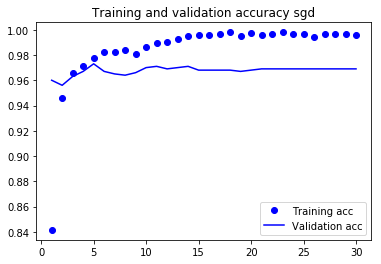

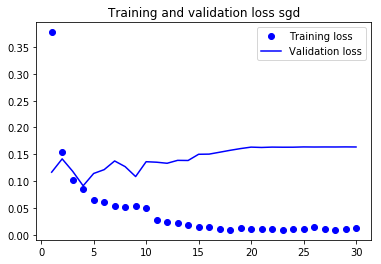

In [25]:
acc = history_adam.history['acc']
val_acc = history_adam.history['val_acc']
loss = history_adam.history['loss']
val_loss = history_adam.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy sgd')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss sgd')
plt.legend()
plt.show()

### sgd

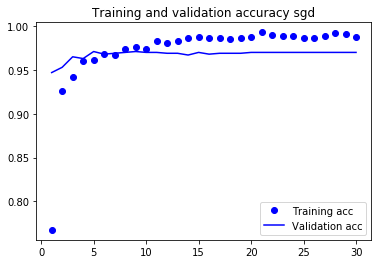

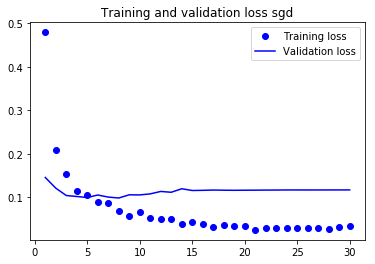

In [26]:
acc = history_sgd.history['acc']
val_acc = history_sgd.history['val_acc']
loss = history_sgd.history['loss']
val_loss = history_sgd.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy sgd')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss sgd')
plt.legend()
plt.show()

### sgd with momentum 0.9 and nestrov

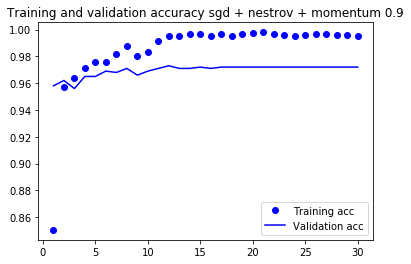

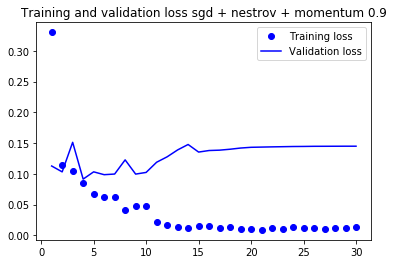

In [19]:
acc = history_sgd_nes_mom9.history['acc']
val_acc = history_sgd_nes_mom9.history['val_acc']
loss = history_sgd_nes_mom9.history['loss']
val_loss = history_sgd_nes_mom9.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy sgd + nestrov + momentum 0.9')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss sgd + nestrov + momentum 0.9')
plt.legend()
plt.show()


### sgd with nestrov

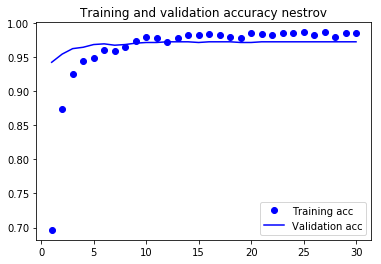

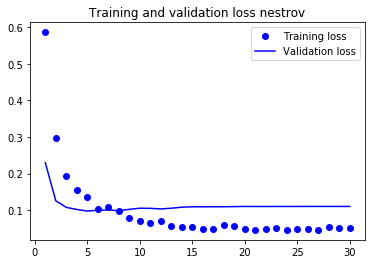

In [20]:
acc = history_sgd_nes.history['acc']
val_acc = history_sgd_nes.history['val_acc']
loss = history_sgd_nes.history['loss']
val_loss = history_sgd_nes.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy nestrov')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss nestrov')
plt.legend()
plt.show()

## Visualize and compare val. acc

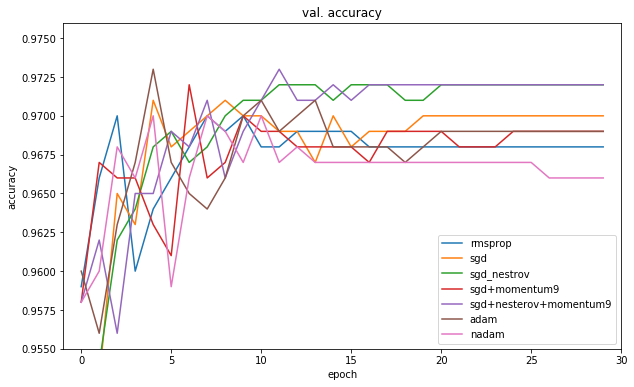

In [27]:
plt.figure(figsize=(10, 6))  
plt.axis((-1,30,0.955,0.976))

plt.plot(history_rmsprop.history['val_acc'])
plt.plot(history_sgd.history['val_acc'])
plt.plot(history_sgd_nes.history['val_acc'])
plt.plot(history_sgd_mom9.history['val_acc'])
plt.plot(history_sgd_nes_mom9.history['val_acc'])
plt.plot(history_adam.history['val_acc'])
plt.plot(history_nadam.history['val_acc'])

plt.title('val. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['rmsprop', 'sgd', 'sgd_nestrov', 'sgd+momentum9', 'sgd+nesterov+momentum9', 'adam', 'nadam'], loc='lower right')

plt.show()

## Visualize and compare val. loss

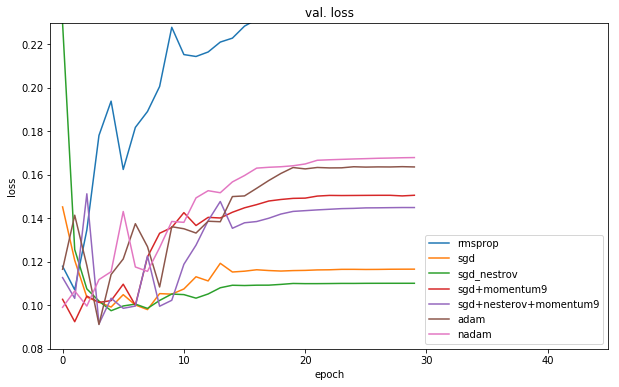

In [28]:
plt.figure(figsize=(10, 6))  
plt.axis((-1,45,0.08,0.23))

plt.plot(history_rmsprop.history['val_loss'])
plt.plot(history_sgd.history['val_loss'])
plt.plot(history_sgd_nes.history['val_loss'])
plt.plot(history_sgd_mom9.history['val_loss'])
plt.plot(history_sgd_nes_mom9.history['val_loss'])
plt.plot(history_adam.history['val_loss'])
plt.plot(history_nadam.history['val_loss'])

plt.title('val. loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['rmsprop', 'sgd', 'sgd_nestrov', 'sgd+momentum9', 'sgd+nesterov+momentum9', 'adam', 'nadam'], loc='lower right')  

plt.show()

## Visualize and compare trn. acc

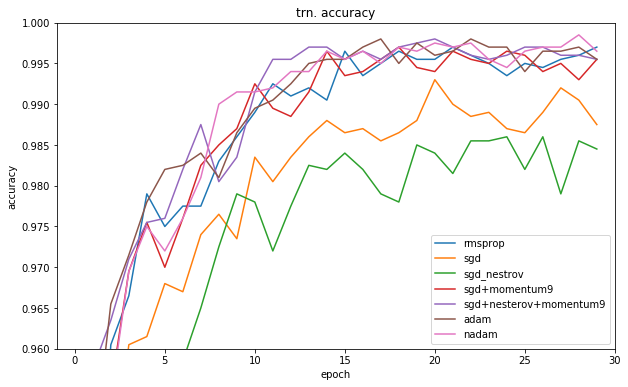

In [29]:
plt.figure(figsize=(10, 6))  
plt.axis((-1,30,0.96,1.0))

plt.plot(history_rmsprop.history['acc'])
plt.plot(history_sgd.history['acc'])
plt.plot(history_sgd_nes.history['acc'])
plt.plot(history_sgd_mom9.history['acc'])
plt.plot(history_sgd_nes_mom9.history['acc'])
plt.plot(history_adam.history['acc'])
plt.plot(history_nadam.history['acc'])

plt.title('trn. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['rmsprop', 'sgd', 'sgd_nestrov', 'sgd+momentum9', 'sgd+nesterov+momentum9', 'adam', 'nadam'], loc='lower right')

plt.show()

## Visualize and compare trn. loss

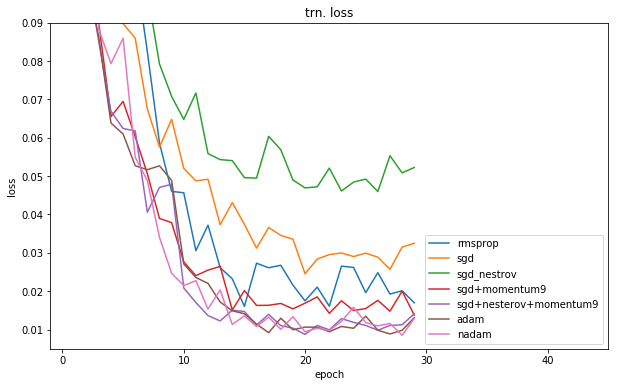

In [24]:
plt.figure(figsize=(10, 6))  
plt.axis((-1,45,0.005,0.09))

plt.plot(history_rmsprop.history['loss'])
plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd_nes.history['loss'])
plt.plot(history_sgd_mom9.history['loss'])
plt.plot(history_sgd_nes_mom9.history['loss'])
plt.plot(history_adam.history['loss'])
plt.plot(history_nadam.history['loss'])

plt.title('trn. loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['rmsprop', 'sgd', 'sgd_nestrov', 'sgd+momentum9', 'sgd+nesterov+momentum9', 'adam', 'nadam'], loc='lower right')  

plt.show()